In [1]:
# import the necessary packages

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns


# DBSCAN algorithm
We perform the density-based clustering using DBSCAN (Density-Based Spatial Clustering of Applications with Noise) algorithm.
It has only two parameters...

- eps: The maximum distance between two samples for them to be considered as in the same neighborhood.
- min_samples: the minimum number of points needed to create a cluster.
... and one output:
- cluster labels for each point in the dataset. Noisy samples are given the label -1.

## Pre-processing
We will use the normalized dataset with Min-Max approach to perform DBSCAN.

<Axes: >

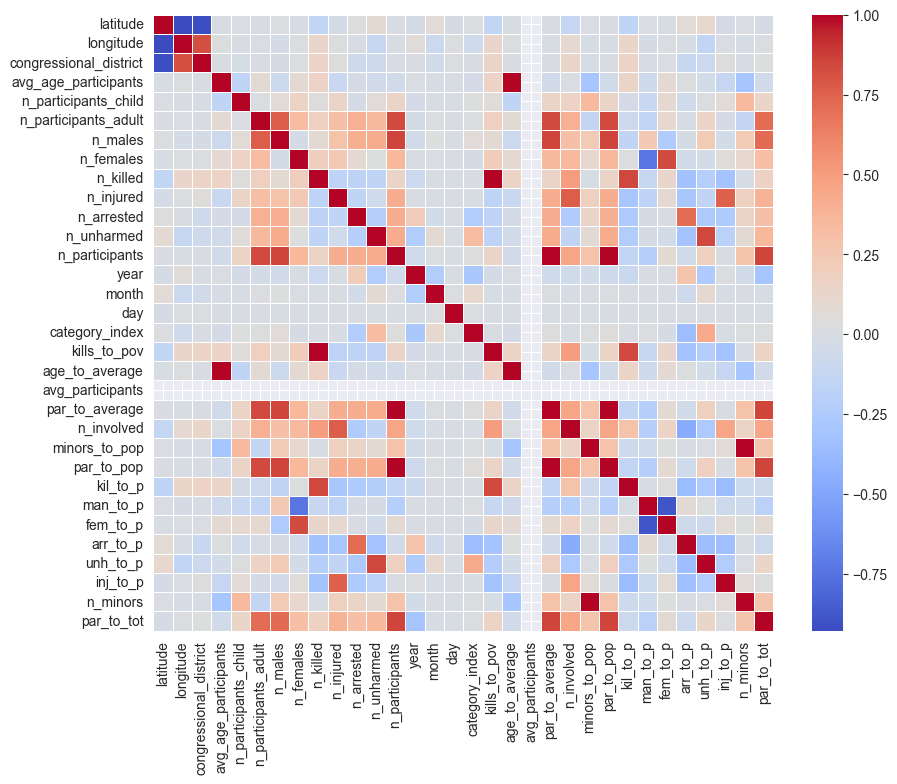

In [2]:
df = pd.read_csv('../data/extracted_features.csv')

standard = StandardScaler()
minmax = MinMaxScaler()

#pick the California data
df = df[df['state'] == 'California']
df = df.dropna(subset=['n_participants', 'n_involved', 'age_to_average', 'par_to_tot'])

# plot correlation matrix to see if there is any feature to drop
plt.figure(figsize=(10, 8))
correlation_matrix = df.select_dtypes(include='number').corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5, annot_kws={"size": 10})

In [3]:
df[['n_participants', 'n_involved', 'age_to_average', 'par_to_tot']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 13684 entries, 12356 to 86292
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   n_participants  13684 non-null  int64  
 1   n_involved      13684 non-null  int64  
 2   age_to_average  13684 non-null  float64
 3   par_to_tot      13684 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 534.5 KB


In [4]:

new_df = df[['n_participants', 'n_involved', 'age_to_average', 'par_to_tot']]
#new_df = df[['n_participants', 'n_involved', 'age_to_average', 'par_to_tot', 'category_index']]

# remove highly correlated features

# scale the data
ss_scaled = standard.fit_transform(new_df)
mm_scaled = minmax.fit_transform(new_df)

In [5]:
from scipy.spatial.distance import pdist, squareform
import tqdm


def calc_k_nn_dist_graph(X, ub=0., lb=0.):
    # List of k (for k-th nearest neighbour)
    k_list = [3, 5, 9]

    dist = pdist(X, 'euclidean')  # Pairwise distance
    dist = squareform(dist)  # Distance matrix given the vector dist

    # Calculate sorted list of distances for points for each k
    for k in k_list:
        kth_distances = []
        for d in dist:
            index_kth_distance = np.argsort(d)[k]
            kth_distances.append(d[index_kth_distance])

        # Plot the graph of distance from k-th nearest neighbour
        plt.figure(figsize=(8, 6))
        plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
        plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
        plt.xlabel('sorted distances', fontsize=18)
        plt.tick_params(axis='both', which='major', labelsize=12)
        plt.grid()
        plt.axhline(ub)
        plt.axhline(lb)
        plt.show()


def db_scan_function(X, eps_list, minpts_list):
    # Table with dim = len(eps_list) x len(minpts_list)
    clustering_results = []

    # Total number of combinations
    total_combinations = len(eps_list) * len(minpts_list)
    current_combination = 0

    # Iterate over eps (rows)
    for eps in eps_list:
        minpts_results = []

        # Iterate over minpts
        for minpts in minpts_list:
            dbscan = DBSCAN(eps=eps, min_samples=minpts, n_jobs=-1)
            dbscan.fit(X)  # Fit the DBSCAN model to the data
            minpts_results.append(dbscan)  # Store the DBSCAN model

            # Update progress
            current_combination += 1
            print(f"Progress: {current_combination}/{total_combinations}")

        clustering_results.append(minpts_results)

    return clustering_results


def print_dbscan(dbscan_table, eps_values, min_samples, dataframe):
    data = []
    columns = ['eps\\minpts'] + [str(minpt) for minpt in min_samples]

    for i, eps in enumerate(eps_values):
        row_data = [str(eps)]
        for j, minpts in enumerate(min_samples):
            dbscan = dbscan_table[i][j]

            try:  # Exception in case of num_clusters=1
                silhouette = round(silhouette_score(dataframe, dbscan.labels_), 2)
            except:
                silhouette = np.nan
            cell_str = str(silhouette) + '-n_clust:' + str(len(np.unique(dbscan.labels_)) - 1)
            row_data.append(cell_str)

        data.append(row_data)

    return pd.DataFrame(data, columns=columns)


In [24]:
# values of min_samples to try
min_samples = range(3, 15, 2)

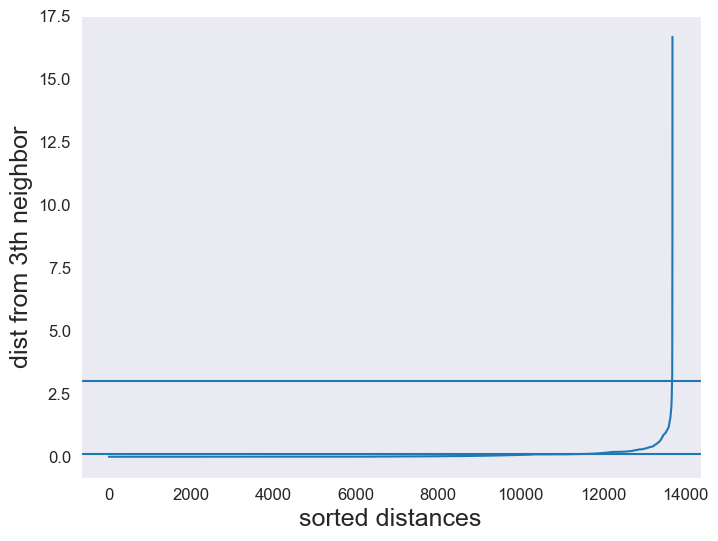

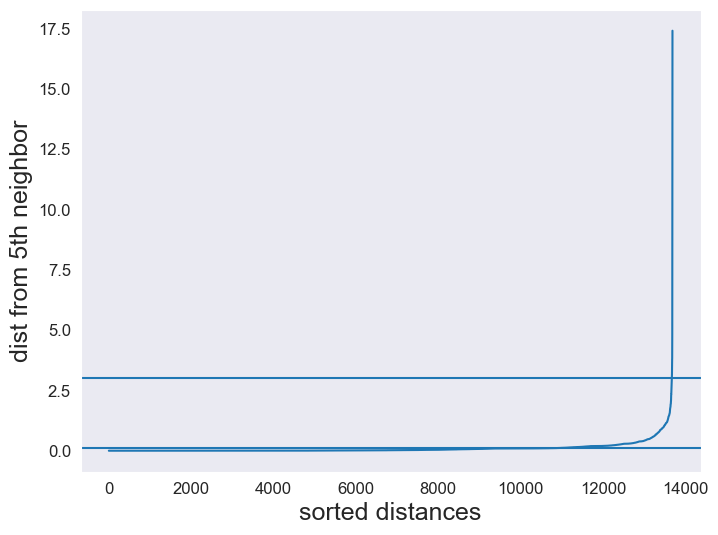

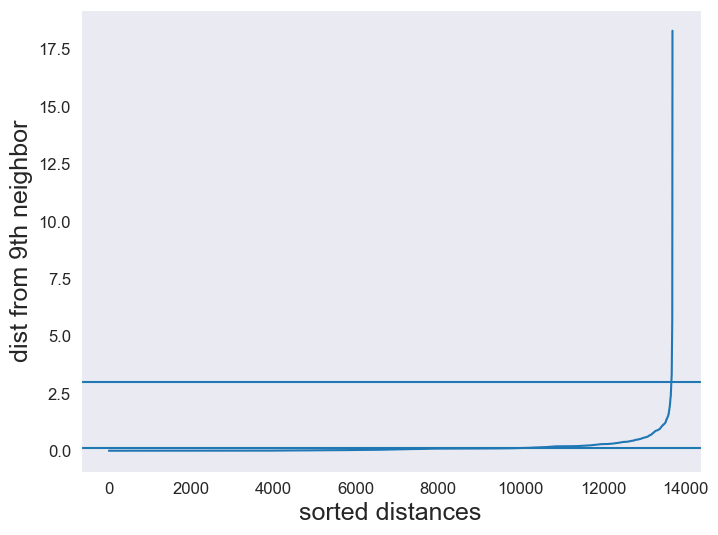

In [7]:

# values of eps to try
ss_eps_values = np.linspace(0.1, 3, 10)

#repeat the same for standard scaled data
calc_k_nn_dist_graph(ss_scaled, 0.1, 3)

In [11]:
#dbscan_table = db_scan_function(ss_scaled, ss_eps_values, min_samples)
#scalar_result = print_dbscan(dbscan_table, ss_eps_values, min_samples, ss_scaled)
#scalar_result

Progress: 1/90
Progress: 2/90
Progress: 3/90
Progress: 4/90
Progress: 5/90
Progress: 6/90
Progress: 7/90
Progress: 8/90
Progress: 9/90
Progress: 10/90
Progress: 11/90
Progress: 12/90
Progress: 13/90
Progress: 14/90
Progress: 15/90
Progress: 16/90
Progress: 17/90
Progress: 18/90
Progress: 19/90
Progress: 20/90
Progress: 21/90
Progress: 22/90
Progress: 23/90
Progress: 24/90
Progress: 25/90
Progress: 26/90
Progress: 27/90
Progress: 28/90
Progress: 29/90
Progress: 30/90
Progress: 31/90
Progress: 32/90
Progress: 33/90
Progress: 34/90
Progress: 35/90
Progress: 36/90
Progress: 37/90
Progress: 38/90
Progress: 39/90
Progress: 40/90
Progress: 41/90
Progress: 42/90
Progress: 43/90
Progress: 44/90
Progress: 45/90
Progress: 46/90
Progress: 47/90
Progress: 48/90
Progress: 49/90
Progress: 50/90
Progress: 51/90
Progress: 52/90
Progress: 53/90
Progress: 54/90
Progress: 55/90
Progress: 56/90
Progress: 57/90
Progress: 58/90
Progress: 59/90
Progress: 60/90
Progress: 61/90
Progress: 62/90
Progress: 63/90
P

,eps\minpts,3,5,7,9,11,13,15,17,19
0,0.1,-0.2-n_clust:264,-0.26-n_clust:111,-0.26-n_clust:67,-0.31-n_clust:46,-0.26-n_clust:40,-0.29-n_clust:35,-0.22-n_clust:29,-0.23-n_clust:25,-0.28-n_clust:15
1,0.42222222222222217,0.15-n_clust:66,0.17-n_clust:41,0.13-n_clust:29,0.14-n_clust:28,0.18-n_clust:24,0.18-n_clust:21,0.18-n_clust:20,0.18-n_clust:16,0.18-n_clust:16
2,0.7444444444444444,0.2-n_clust:50,0.22-n_clust:36,0.21-n_clust:31,0.21-n_clust:28,0.21-n_clust:25,0.2-n_clust:24,0.19-n_clust:23,0.19-n_clust:22,0.18-n_clust:20
3,1.0666666666666667,0.21-n_clust:20,0.24-n_clust:11,0.24-n_clust:11,0.24-n_clust:9,0.24-n_clust:9,0.22-n_clust:9,0.24-n_clust:8,0.25-n_clust:8,0.24-n_clust:8
4,1.3888888888888888,0.3-n_clust:8,0.3-n_clust:5,0.31-n_clust:4,0.31-n_clust:4,0.31-n_clust:4,0.31-n_clust:4,0.31-n_clust:4,0.31-n_clust:4,0.31-n_clust:4
5,1.711111111111111,0.62-n_clust:6,0.75-n_clust:1,0.74-n_clust:1,0.74-n_clust:1,0.73-n_clust:1,0.72-n_clust:1,0.71-n_clust:1,0.71-n_clust:1,0.71-n_clust:1
6,2.033333333333333,0.72-n_clust:4,0.77-n_clust:1,0.77-n_clust:1,0.77-n_clust:1,0.76-n_clust:1,0.75-n_clust:1,0.75-n_clust:1,0.75-n_clust:1,0.75-n_clust:1
7,2.3555555555555556,0.75-n_clust:3,0.75-n_clust:2,0.79-n_clust:1,0.78-n_clust:1,0.78-n_clust:1,0.78-n_clust:1,0.78-n_clust:1,0.77-n_clust:1,0.77-n_clust:1
8,2.6777777777777776,0.78-n_clust:2,0.78-n_clust:2,0.81-n_clust:1,0.8-n_clust:1,0.79-n_clust:1,0.79-n_clust:1,0.79-n_clust:1,0.79-n_clust:1,0.79-n_clust:1
9,3.0,0.85-n_clust:1,0.85-n_clust:1,0.82-n_clust:1,0.81-n_clust:1,0.81-n_clust:1,0.8-n_clust:1,0.8-n_clust:1,0.8-n_clust:1,0.8-n_clust:1


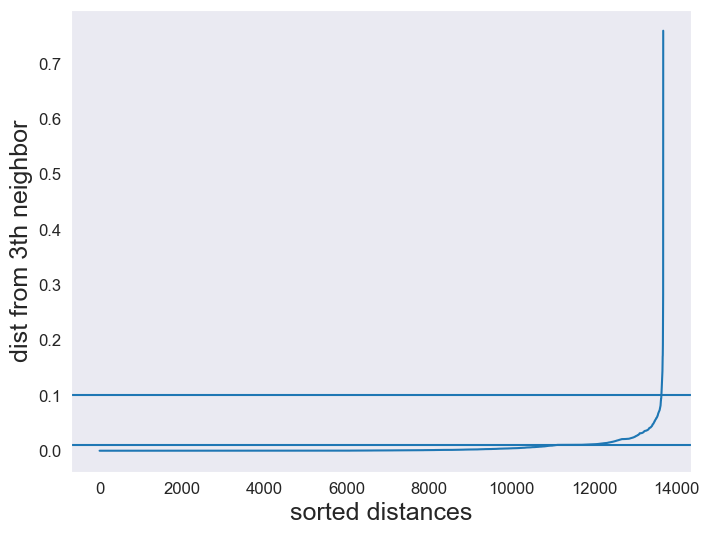

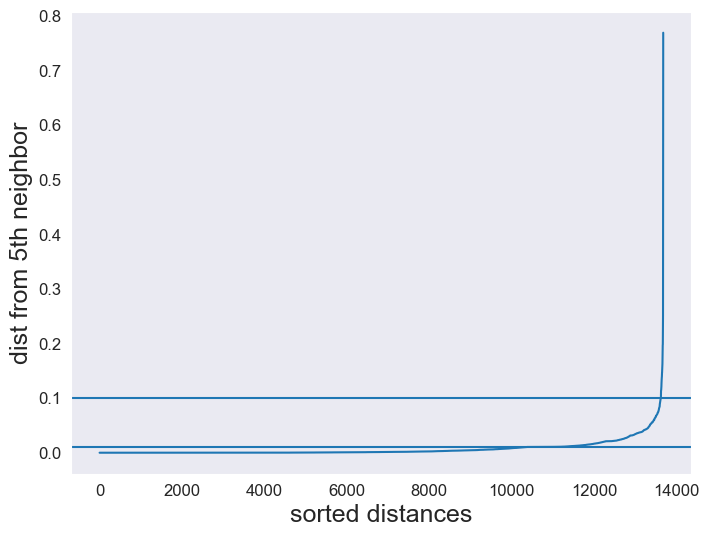

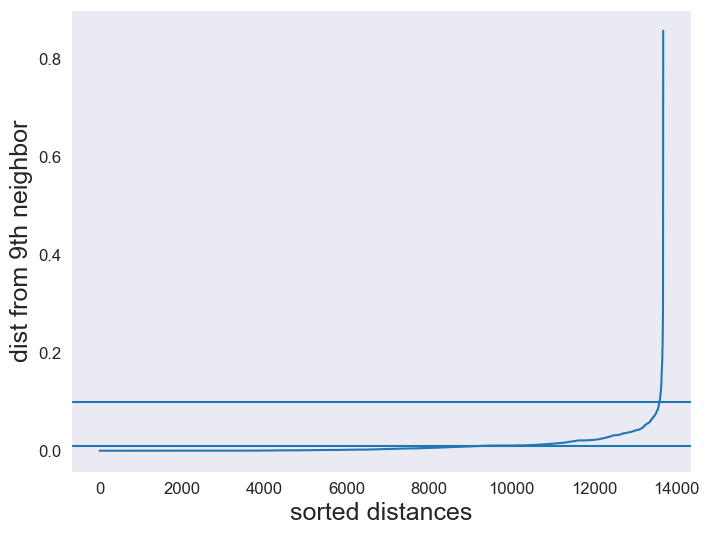

In [8]:
# values of eps to try
mm_eps_values = np.linspace(0.03, 0.1, 10)
calc_k_nn_dist_graph(mm_scaled, 0.01, 0.1)

In [9]:
#dbscan_table = db_scan_function(mm_scaled, mm_eps_values, min_samples)
#minmax_result = print_dbscan(dbscan_table, mm_eps_values, min_samples, mm_scaled)
#minmax_result

In [10]:
def print_best_params(silhouette_scores, parameter_combinations):
    best_score_index = np.argmax(silhouette_scores)  # Get the index of the maximum silhouette score
    best_params = parameter_combinations[best_score_index]  # Retrieve parameters corresponding to the best score

    best_eps, best_min_samples, n_clusters = best_params  # Unpack the best parameters

    best_score = silhouette_scores[best_score_index]  # Get the best silhouette score

    # Print the best silhouette score and corresponding parameters
    print(f"Best Silhouette Score: {best_score}")
    print(f"Best Parameters - eps: {best_eps}, min_samples: {best_min_samples}", f"Number of clusters: {n_clusters}")
    return best_eps, best_min_samples

# MinMax Scaling Test

In [11]:
mm_eps_values = np.linspace(0.04, 0.1, 10)

In [12]:
# test the best parameters for the DBSCAN algorithm
silhouette_scores = []
parameter_combinations = []

best_score = -1  # Initialize best silhouette score
best_params = {'eps': None, 'min_samples': None, 'n_clusters': None}
for eps in mm_eps_values:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(mm_scaled)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 3 or len(unique_labels) > 50: continue
        silhouette = silhouette_score(mm_scaled, labels)
        print(
            f"Number of clusters: {len(unique_labels)}, eps: {eps}, min_samples: {min_sample} , Silhouette score: {silhouette}")
        silhouette_scores.append(silhouette)
        parameter_combinations.append((eps, min_sample, len(unique_labels)))

# Plotting the results
silhouette_scores = np.array(silhouette_scores)
parameter_combinations = np.array(parameter_combinations)


Number of clusters: 24, eps: 0.04, min_samples: 3 , Silhouette score: 0.03165199661966632
Number of clusters: 13, eps: 0.04, min_samples: 5 , Silhouette score: 0.0411153117491976
Number of clusters: 7, eps: 0.04, min_samples: 7 , Silhouette score: 0.08287151591075664
Number of clusters: 8, eps: 0.04, min_samples: 9 , Silhouette score: 0.07790770332739703
Number of clusters: 9, eps: 0.04, min_samples: 11 , Silhouette score: 0.05091451967058935
Number of clusters: 8, eps: 0.04, min_samples: 13 , Silhouette score: 0.07794557008050314
Number of clusters: 7, eps: 0.04, min_samples: 15 , Silhouette score: 0.09289939300513562
Number of clusters: 7, eps: 0.04, min_samples: 17 , Silhouette score: 0.092266943273917
Number of clusters: 7, eps: 0.04, min_samples: 19 , Silhouette score: 0.09002051825431429
Number of clusters: 19, eps: 0.04666666666666667, min_samples: 3 , Silhouette score: 0.04761662873491999
Number of clusters: 11, eps: 0.04666666666666667, min_samples: 5 , Silhouette score: 0.074

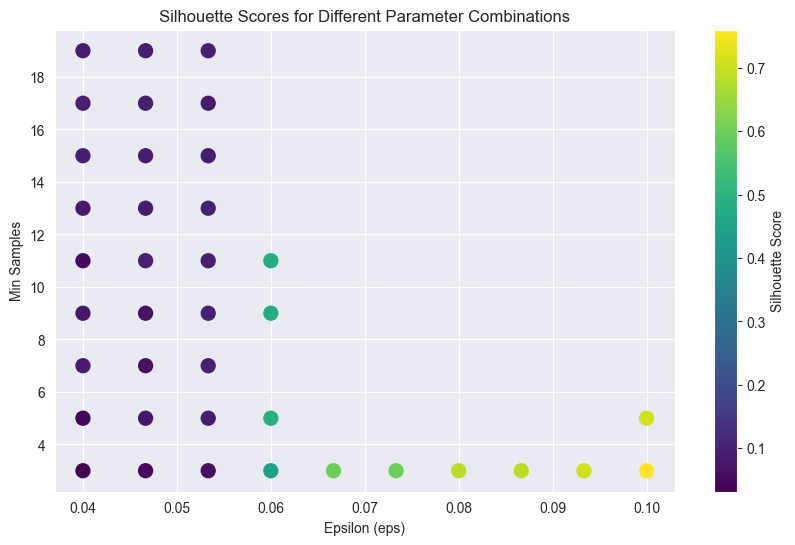

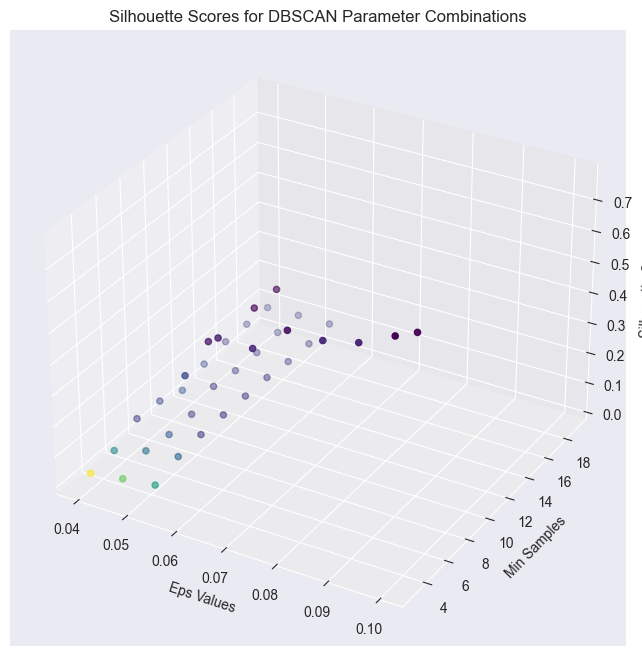

Best Silhouette Score: 0.7598029680173297
Best Parameters - eps: 0.1, min_samples: 3.0 Number of clusters: 3.0


In [13]:
eps_values = parameter_combinations[:, 0]
min_samples_values = parameter_combinations[:, 1]
n_clusters = parameter_combinations[:, 2]

plt.figure(figsize=(10, 6))
plt.scatter(eps_values, min_samples_values, c=silhouette_scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(eps_values, min_samples_values, silhouette_scores, c=n_clusters, cmap='viridis')
ax.set_xlabel('Eps Values')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Silhouette Scores for DBSCAN Parameter Combinations')

plt.show()

best_eps, best_min_samples = print_best_params(silhouette_scores, parameter_combinations)

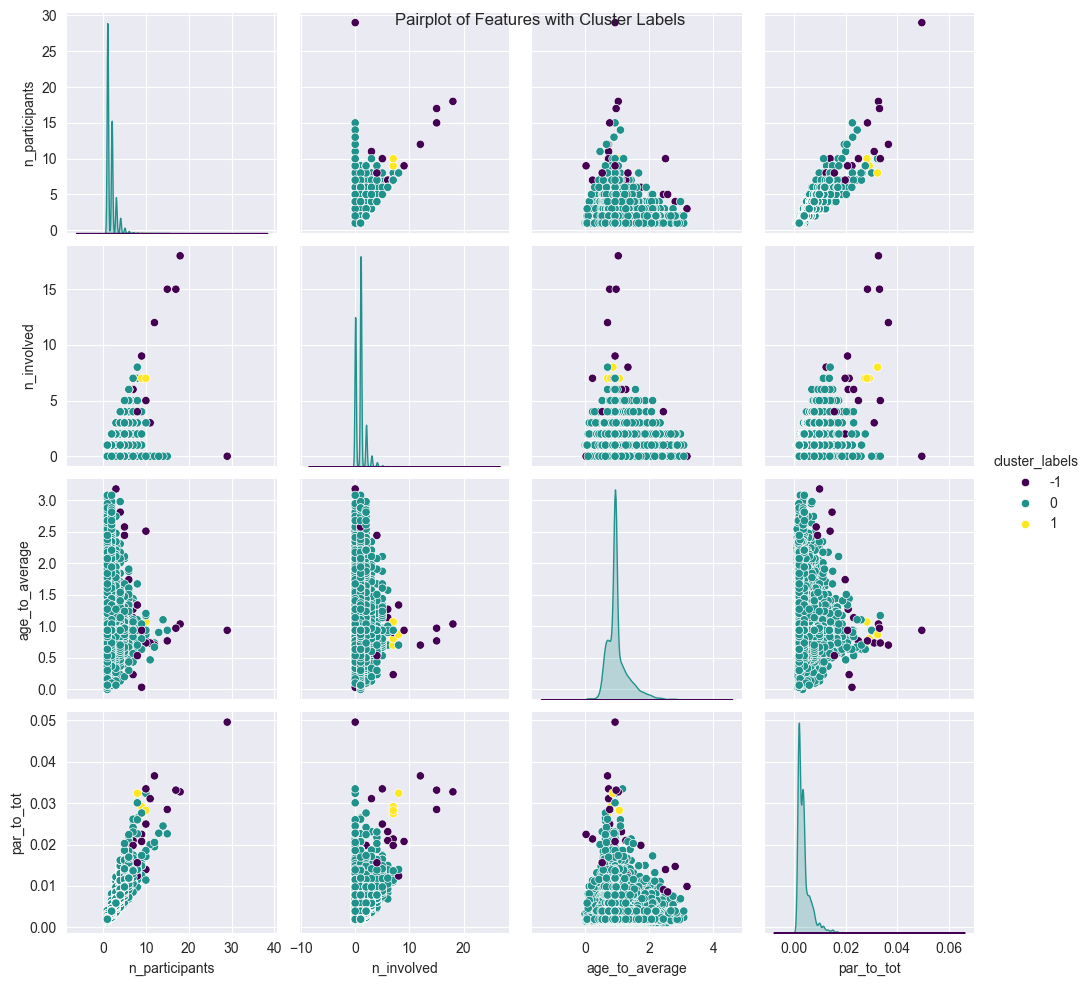

cluster_labels
 0    13658
-1       22
 1        4
Name: count, dtype: int64

In [16]:
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
cluster_labels = dbscan.fit_predict(mm_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()


Cluster 0
       n_participants  n_involved  age_to_average  par_to_tot  cluster_labels
12356               1           1        0.635353    0.001621               0
12357               1           0        0.936310    0.001621               0
12358               1           1        0.936310    0.001621               0
12359               3           1        1.036628    0.004862               0
12360               1           0        1.170387    0.001621               0


Cluster -1
       n_participants  n_involved  age_to_average  par_to_tot  cluster_labels
13129              10           0        2.507972    0.013947              -1
20363              12          12        0.702232    0.036585              -1
20402               7           7        0.234077    0.021341              -1
20949              10           5        0.769111    0.024938              -1
21027               9           0        0.033440    0.022444              -1


Cluster 1
       n_participants  n_invo

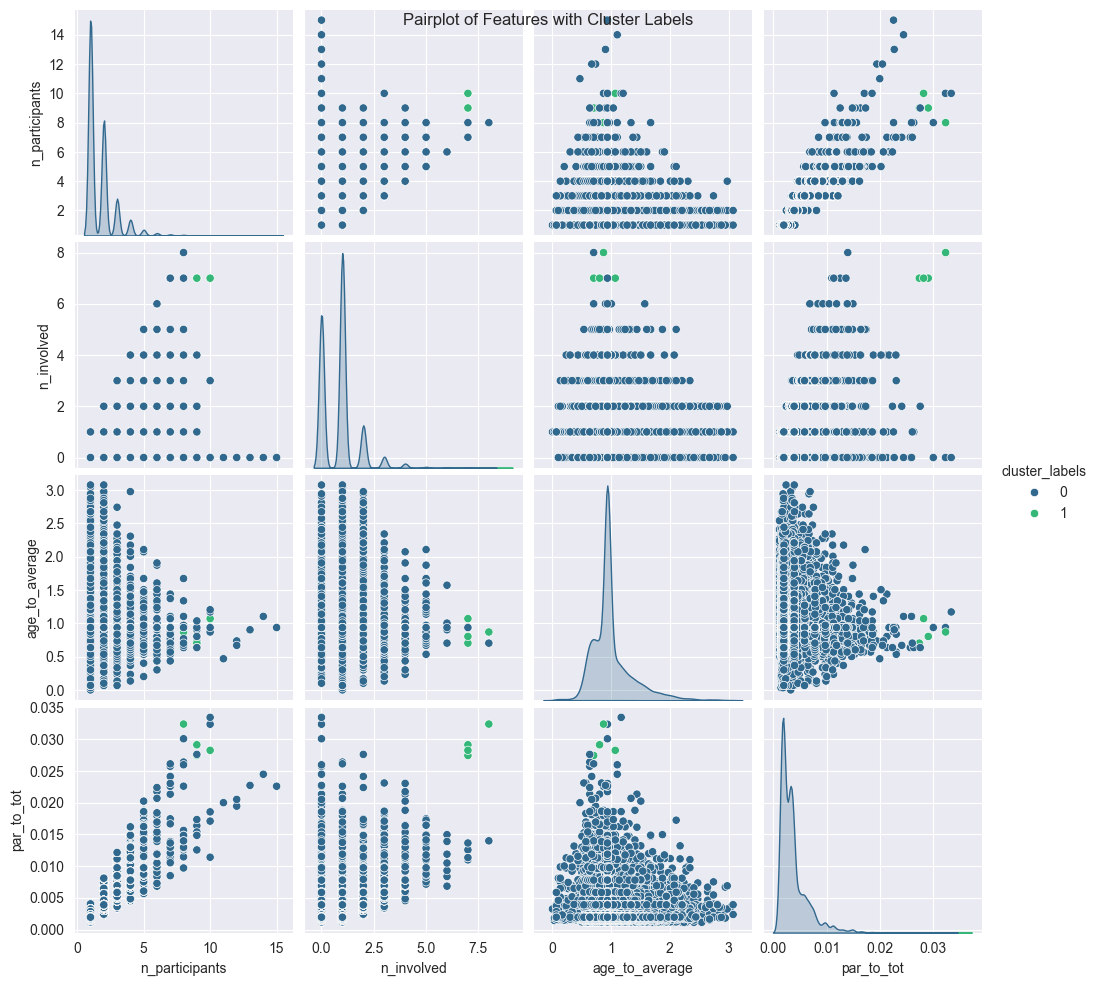

cluster_labels
0    13658
1        4
Name: count, dtype: int64

In [17]:
# print examples for each cluster
for i in selected_data['cluster_labels'].unique():
    print(f"Cluster {i}")
    print(selected_data[selected_data['cluster_labels'] == i].head())
    print("\n")
    
selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis')
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()
selected_data['cluster_labels'].value_counts()

# Standard Scaling Test

In [21]:
ss_eps_values = np.linspace(0.2, 2.0, 10)

In [22]:
silhouette_scores = []
parameter_combinations = []

best_score = -1  # Initialize best silhouette score
best_params = {'eps': None, 'min_samples': None}

for eps in ss_eps_values:
    for min_sample in min_samples:
        dbscan = DBSCAN(eps=eps, min_samples=min_sample)
        labels = dbscan.fit_predict(ss_scaled)

        unique_labels = np.unique(labels)
        if len(unique_labels) < 4 or len(unique_labels) > 50: continue
        silhouette = silhouette_score(ss_scaled, labels)
        print(
            f"Number of clusters: {len(unique_labels)}, eps: {eps}, min_samples: {min_sample} , Silhouette score: {silhouette}")
        silhouette_scores.append(silhouette)
        parameter_combinations.append((eps, min_sample, len(unique_labels)))

# Plotting the results
silhouette_scores = np.array(silhouette_scores)
parameter_combinations = np.array(parameter_combinations)


Number of clusters: 43, eps: 0.2, min_samples: 9 , Silhouette score: 0.15807846960117297
Number of clusters: 33, eps: 0.2, min_samples: 11 , Silhouette score: 0.12865281498190667
Number of clusters: 23, eps: 0.2, min_samples: 13 , Silhouette score: 0.12381187136860694
Number of clusters: 27, eps: 0.2, min_samples: 15 , Silhouette score: 0.13586606755057648
Number of clusters: 18, eps: 0.2, min_samples: 17 , Silhouette score: 0.14050809215747465
Number of clusters: 17, eps: 0.2, min_samples: 19 , Silhouette score: 0.13726158847954387
Number of clusters: 36, eps: 0.4, min_samples: 5 , Silhouette score: 0.23263325202412458
Number of clusters: 25, eps: 0.4, min_samples: 7 , Silhouette score: 0.2456208981231996
Number of clusters: 23, eps: 0.4, min_samples: 9 , Silhouette score: 0.252148108358041
Number of clusters: 22, eps: 0.4, min_samples: 11 , Silhouette score: 0.24379931909118804
Number of clusters: 20, eps: 0.4, min_samples: 13 , Silhouette score: 0.23975410388452104
Number of cluster

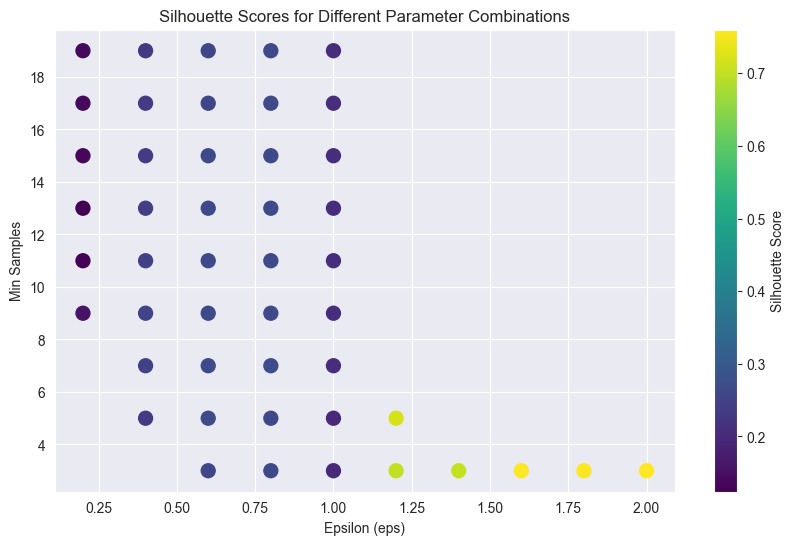

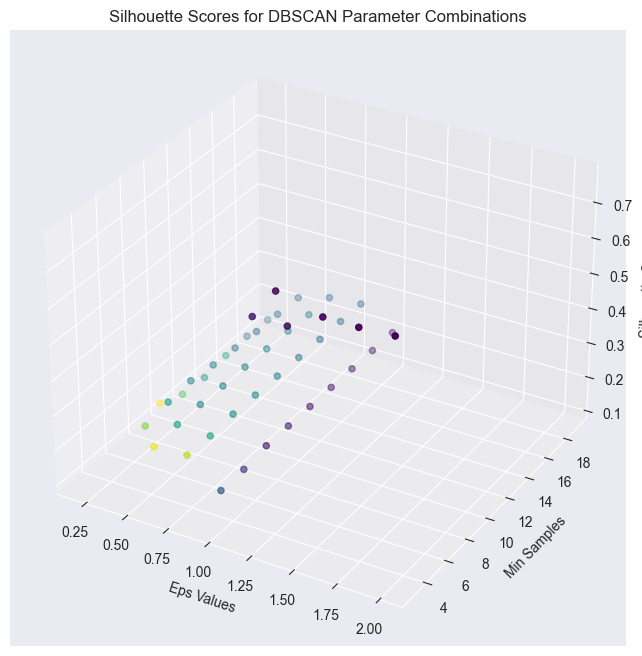

Best Silhouette Score: 0.7600654321310294
Best Parameters - eps: 2.0, min_samples: 3.0 Number of clusters: 4.0


In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(parameter_combinations[:, 0], parameter_combinations[:, 1], c=silhouette_scores, cmap='viridis', s=100)
plt.colorbar(label='Silhouette Score')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Min Samples')
plt.title('Silhouette Scores for Different Parameter Combinations')
plt.grid(True)
plt.show()

eps_values = parameter_combinations[:, 0]
min_samples_values = parameter_combinations[:, 1]
clusters = parameter_combinations[:, 2]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(eps_values, min_samples_values, silhouette_scores, c=clusters, cmap='viridis')
ax.set_xlabel('Eps Values')
ax.set_ylabel('Min Samples')
ax.set_zlabel('Silhouette Score')
ax.set_title('Silhouette Scores for DBSCAN Parameter Combinations')

plt.show()

best_eps, best_min_samples = print_best_params(silhouette_scores, parameter_combinations)

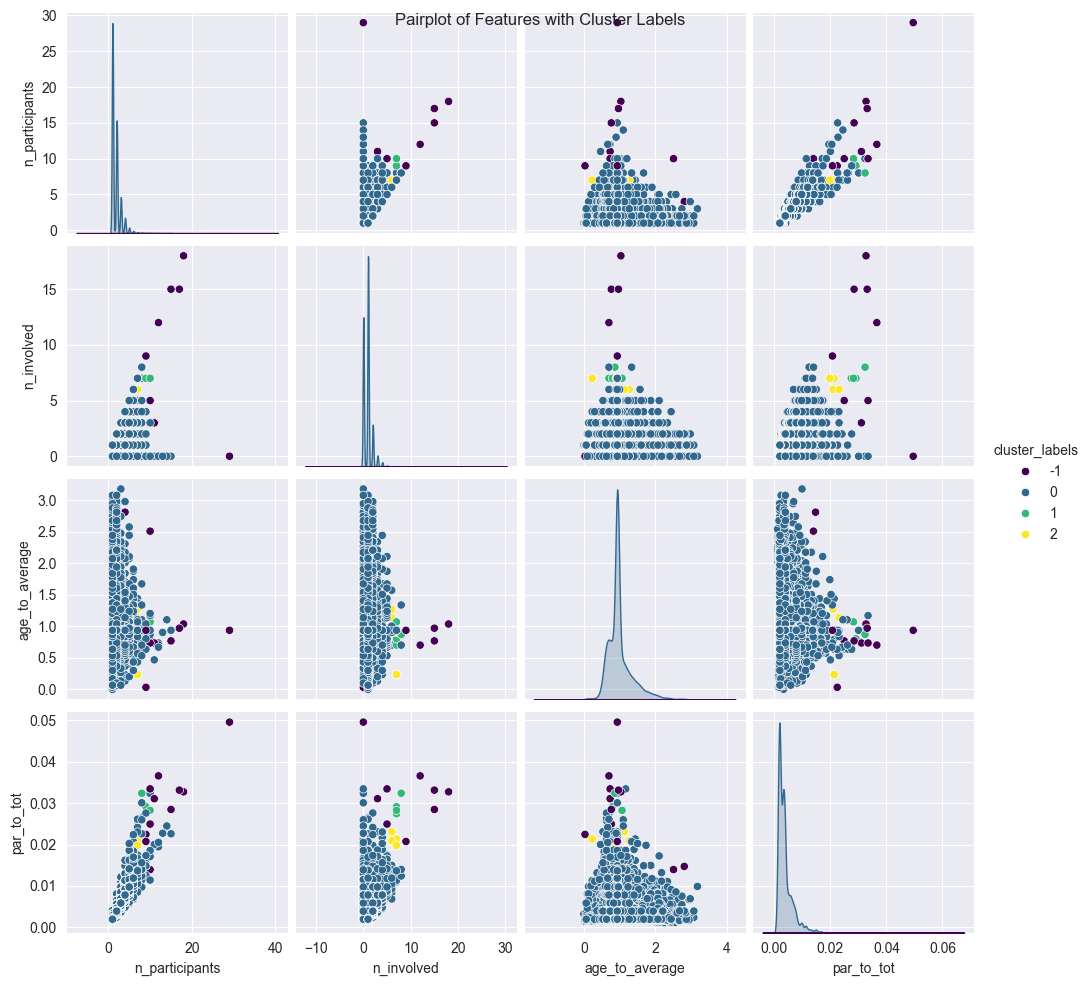

cluster_labels
 0    13664
-1       12
 1        4
 2        4
Name: count, dtype: int64

In [25]:
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
cluster_labels = dbscan.fit_predict(ss_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis',markers=['o', 's', '^', 'D'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

C:\Users\Hp\Desktop\DataMining\env\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\Hp\Desktop\DataMining\env\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\Hp\Desktop\DataMining\env\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\Hp\Desktop\DataMining\env\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)
C:\Users\Hp\Desktop\DataMining\env\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  func(x=x, y=y, **kwargs)


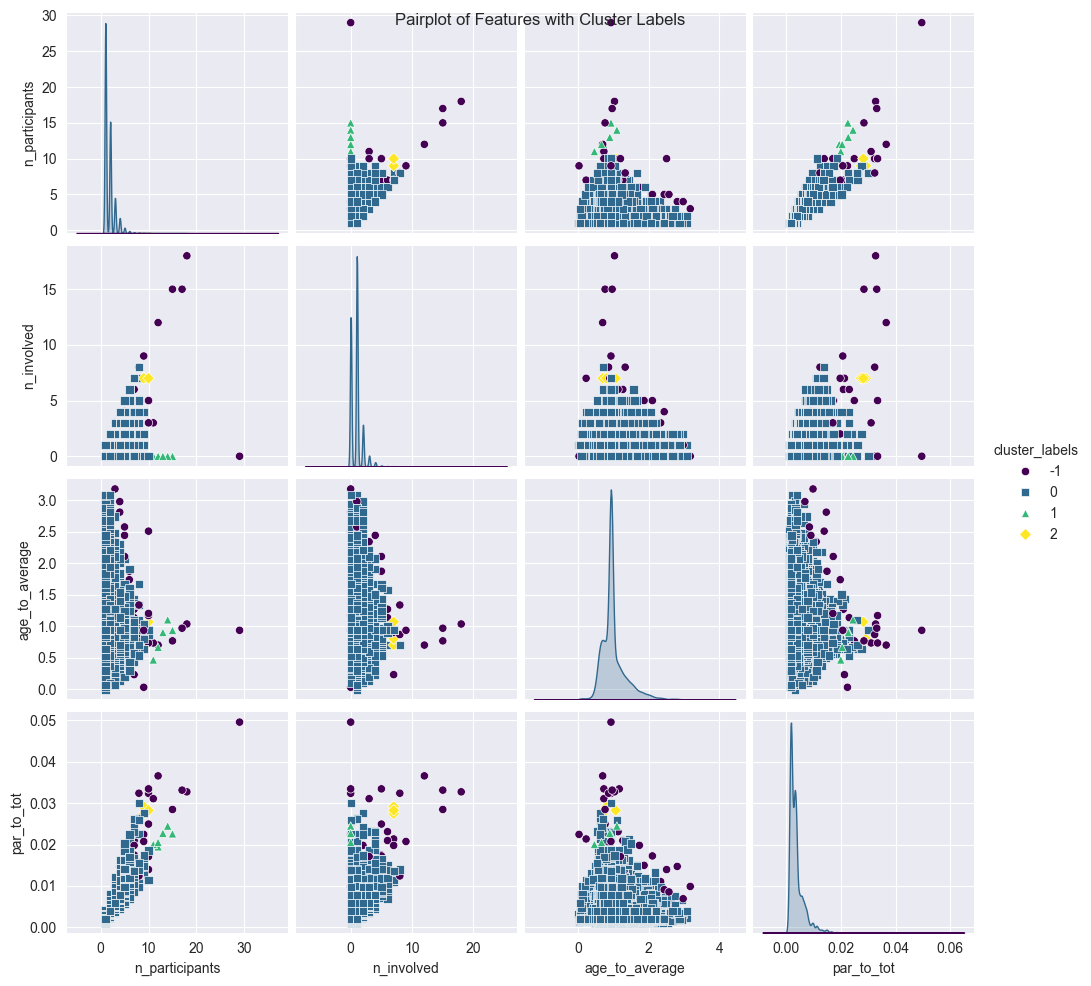

cluster_labels
 0    13645
-1       30
 1        6
 2        3
Name: count, dtype: int64

In [20]:
# 1.32, 3 without cat index
dbscan = DBSCAN(eps=1.5, min_samples=3)
cluster_labels = dbscan.fit_predict(ss_scaled)
selected_data = new_df.copy()
selected_data['cluster_labels'] = cluster_labels
#selected_data = selected_data[selected_data['cluster_labels'] != -1]
sns.pairplot(selected_data, hue='cluster_labels', palette='viridis', markers=['o', 's', '^', 'D', 'p', 'X'])
plt.suptitle('Pairplot of Features with Cluster Labels')
plt.show()

#count size of each cluster
selected_data['cluster_labels'].value_counts()

In [ ]:
import plotly.express as px

if False:
    fig = px.scatter_mapbox(
        pd.merge(selected_data, df, how="right"), lat='latitude', lon='longitude',
        color='cluster_labels', mapbox_style="carto-positron",
        zoom=3, width=1000, height=600
    )
    fig.show()